# Лабораторная работа 1

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

from typing import Callable, Optional


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
warnings.filterwarnings('ignore')
np.random.seed(42)

print(tf.__version__)

2.10.0


1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [3]:
cifar10 = tf.keras.datasets.cifar10

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.

In [5]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

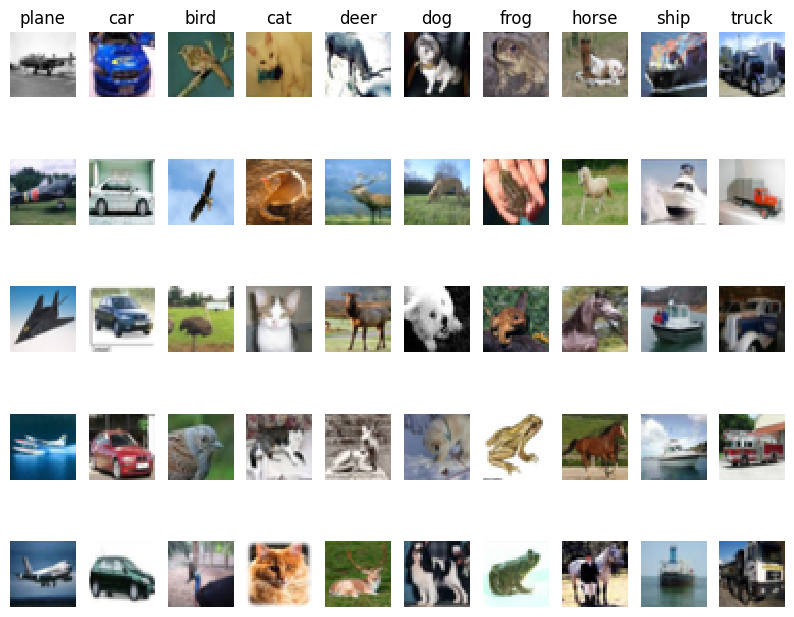

In [6]:
mapping_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
n_classes = len(mapping_labels)
n_samples = 5

for class_index, class_name in enumerate(mapping_labels):
    class_indexes = np.random.choice(np.flatnonzero(y_train == class_index), n_samples, replace=False)
    for i, idx in enumerate(class_indexes):
        plt_idx = i * n_classes + class_index + 1
        plt.subplot(n_samples, n_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(class_name)
plt.show()

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив.

In [7]:
num_train = 5000
train_mask = range(5000)
knn_X_train = X_train[train_mask]
knn_y_train = y_train[train_mask]

num_test = 500
test_mask = range(num_test)
knn_X_test = X_test[test_mask]
knn_y_test = y_test[test_mask]

In [8]:
knn_X_train = np.reshape(knn_X_train, (knn_X_train.shape[0], -1))
knn_y_train = np.reshape(knn_y_train, (knn_y_train.shape[0],))
knn_X_test = np.reshape(knn_X_test, (knn_X_test.shape[0], -1))
knn_y_test = np.reshape(knn_y_test, (knn_y_test.shape[0],))
print(knn_X_train.shape, knn_X_test.shape)

(5000, 3072) (500, 3072)


1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

In [9]:
from scripts.classifiers import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(knn_X_train, knn_y_train)

1.5 Выполните классификацию на тестовой выборке

In [10]:
%%time
knn_dists = classifier.compute_distances_two_loops(knn_X_test)

100%|██████████| 500/500 [00:25<00:00, 19.79it/s]

CPU times: user 25.3 s, sys: 9.85 ms, total: 25.3 s
Wall time: 25.3 s


In [11]:
knn_dists.shape

(500, 5000)

1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


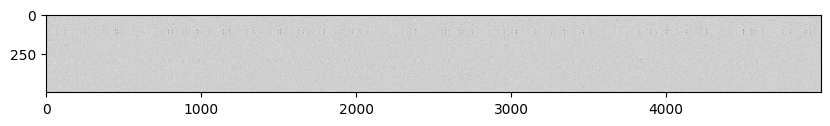

In [12]:
plt.imshow(knn_dists, interpolation='none')
plt.show()


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [13]:
def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.sum(y_pred == y_true) / np.sum(y_true.shape)

In [14]:
knn_y_test_predicts = classifier.predict_labels(knn_dists)
print(f"Accuracy: {accuracy(knn_y_test_predicts, knn_y_test)}")

100%|██████████| 500/500 [00:00<00:00, 3632.89it/s]

Accuracy: 0.176


1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

In [15]:
k_list = range(1, 21)
accuracy_list = []

for k in k_list:
    y_preds = classifier.predict(knn_X_test, k=k, num_loops=2)
    accuracy_list.append(accuracy(y_preds, knn_y_test))

100%|██████████| 500/500 [00:00<00:00, 3558.05it/s]


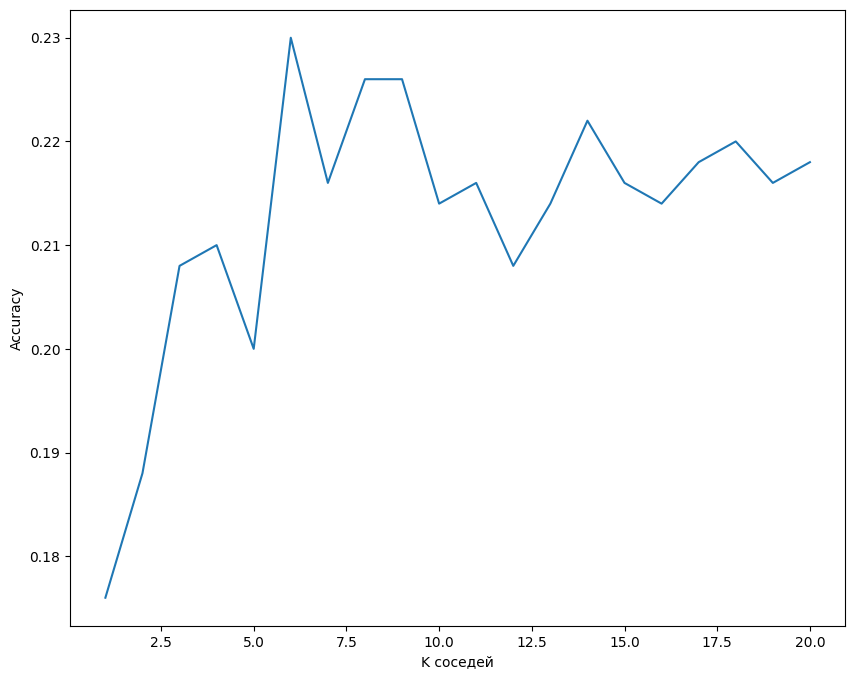

In [16]:
plt.plot(k_list, accuracy_list)
plt.xlabel("K cоседей")
plt.ylabel("Accuracy")
plt.show()

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


In [17]:
k_choices = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100]
print(f"Выборка соседей: {k_choices}")

Выборка соседей: [1, 2, 3, 4, 5, 10, 20, 50, 75, 100]


In [18]:
def cross_val_score(
        estimator,
        X: np.ndarray,
        y: np.ndarray,
        k_folds: int = 5,
        scoring: Optional[Callable[[np.ndarray, np.ndarray], float]] = accuracy,
        estimator_params: Optional[dict] = None,
        train_estimator_params: Optional[dict] = None,
        prediction_estimator_params: Optional[dict] = None,
        verbose: int = 1,
) -> np.ndarray:
    y_folds = np.array_split(y, k_folds)
    X_folds = np.array_split(X, k_folds)

    accuracies = np.zeros((len(y_folds),))

    if verbose > 1:
        print(40 * "=")
        print(f"Cross validation for {estimator.__name__}")
        print(40 * "=")
    for fold in range(len(y_folds)):
        if verbose > 1:
            print(40 * "=")
            print(f"Fold: {fold}")

        y_train_fold = y_folds
        X_train_fold = X_folds

        y_test_fold = y_train_fold[fold]
        X_test_fold = X_train_fold[fold]

        X_train_elements = []
        y_train_elements = []

        for i, element in enumerate(zip(X_folds, y_folds)):
            if i != fold:
                X_train_elements.append(element[0])
                y_train_elements.append(element[1])

        y_train_fold = np.hstack(y_train_elements)
        X_train_fold = np.vstack(X_train_elements)

        if estimator_params:
            estimator_ = estimator(**estimator_params)
        else:
            estimator_ = estimator()

        if train_estimator_params:
            estimator_.train(X_train_fold, y_train_fold, **train_estimator_params)
        else:
            estimator_.train(X_train_fold, y_train_fold)

        if prediction_estimator_params:
            fold_y_pred = estimator_.predict(X_test_fold, **prediction_estimator_params)
        else:
            fold_y_pred = estimator_.predict(X_test_fold)

        if verbose > 1:
            print(f"Score: {scoring(y_test_fold, fold_y_pred)}")
            print(40 * "=")
        accuracies[fold] = scoring(y_test_fold, fold_y_pred)

    return accuracies

In [19]:
cross_val_results = []
for i, k in enumerate(k_choices):
    print(f"================Element {i + 1} from {len(k_choices)} {round((i + 1) / len(k_choices), 2) * 100}% ==========================")
    cross_val_scores = cross_val_score(KNearestNeighbor, knn_X_train, knn_y_train, prediction_estimator_params=dict(k=k))
    cross_val_results.append({
        "k": k,
        "cross_val_scores": cross_val_scores,
    })

================Element 1 from 10 10.0% ==========================


100%|██████████| 1000/1000 [00:00<00:00, 4817.38it/s]


================Element 2 from 10 20.0% ==========================


100%|██████████| 1000/1000 [00:00<00:00, 4827.58it/s]


================Element 3 from 10 30.0% ==========================


100%|██████████| 1000/1000 [00:00<00:00, 4820.26it/s]


================Element 4 from 10 40.0% ==========================


100%|██████████| 1000/1000 [00:00<00:00, 4711.48it/s]


================Element 5 from 10 50.0% ==========================


100%|██████████| 1000/1000 [00:00<00:00, 4727.87it/s]


================Element 6 from 10 60.0% ==========================


100%|██████████| 1000/1000 [00:00<00:00, 4830.02it/s]


================Element 7 from 10 70.0% ==========================


100%|██████████| 1000/1000 [00:00<00:00, 4797.94it/s]


================Element 8 from 10 80.0% ==========================


100%|██████████| 1000/1000 [00:00<00:00, 4725.58it/s]


================Element 9 from 10 90.0% ==========================


100%|██████████| 1000/1000 [00:00<00:00, 4775.14it/s]


================Element 10 from 10 100.0% ==========================


100%|██████████| 1000/1000 [00:00<00:00, 4730.58it/s]


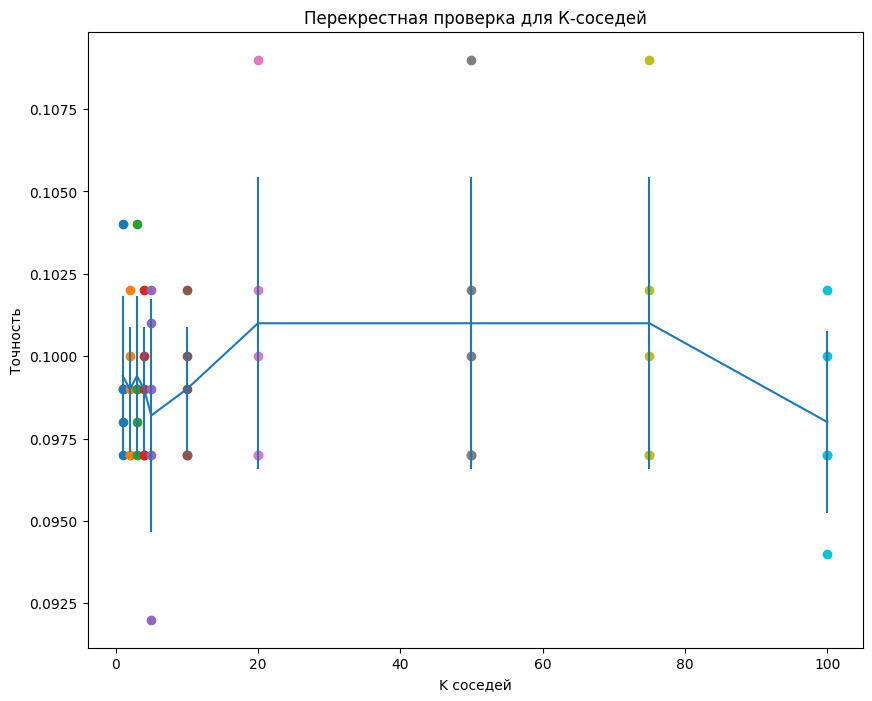

In [20]:
acc_mean = []
acc_std = []

for res in cross_val_results:
    k = res["k"]
    acc = res["cross_val_scores"]
    acc_mean.append(np.mean(acc))
    acc_std.append(np.std(acc))
    plt.scatter([k] * len(acc), acc)

plt.errorbar(k_choices, acc_mean, yerr=acc_std)
plt.title("Перекрестная проверка для К-соседей")
plt.xlabel("K соседей")
plt.ylabel("Точность")
plt.show()

In [21]:
cross_val_df = pd.DataFrame(data=cross_val_results)
cross_val_df.head()

,k,cross_val_scores
0,1,"[0.099, 0.104, 0.097, 0.098, 0.099]"
1,2,"[0.102, 0.1, 0.097, 0.097, 0.099]"
2,3,"[0.099, 0.104, 0.097, 0.098, 0.099]"
3,4,"[0.102, 0.1, 0.097, 0.097, 0.099]"
4,5,"[0.102, 0.101, 0.097, 0.092, 0.099]"


In [22]:
cross_val_df["mean"] = cross_val_df["cross_val_scores"].apply(lambda x: np.mean(x))
cross_val_df["std"] = cross_val_df["cross_val_scores"].apply(lambda x: np.std(x))
cross_val_df

,k,cross_val_scores,mean,std
0,1,"[0.099, 0.104, 0.097, 0.098, 0.099]",0.0994,0.002417
1,2,"[0.102, 0.1, 0.097, 0.097, 0.099]",0.0990,0.001897
2,3,"[0.099, 0.104, 0.097, 0.098, 0.099]",0.0994,0.002417
3,4,"[0.102, 0.1, 0.097, 0.097, 0.099]",0.0990,0.001897
4,5,"[0.102, 0.101, 0.097, 0.092, 0.099]",0.0982,0.003544
5,10,"[0.102, 0.1, 0.097, 0.097, 0.099]",0.0990,0.001897
6,20,"[0.102, 0.1, 0.097, 0.097, 0.109]",0.1010,0.004427
7,50,"[0.102, 0.1, 0.097, 0.097, 0.109]",0.1010,0.004427
8,75,"[0.102, 0.1, 0.097, 0.097, 0.109]",0.1010,0.004427
9,100,"[0.102, 0.1, 0.097, 0.097, 0.094]",0.0980,0.002757


In [23]:
cross_val_df.sort_values(by="mean").sort_values(by="std", ascending=False)

,k,cross_val_scores,mean,std
6,20,"[0.102, 0.1, 0.097, 0.097, 0.109]",0.1010,0.004427
7,50,"[0.102, 0.1, 0.097, 0.097, 0.109]",0.1010,0.004427
8,75,"[0.102, 0.1, 0.097, 0.097, 0.109]",0.1010,0.004427
4,5,"[0.102, 0.101, 0.097, 0.092, 0.099]",0.0982,0.003544
9,100,"[0.102, 0.1, 0.097, 0.097, 0.094]",0.0980,0.002757
0,1,"[0.099, 0.104, 0.097, 0.098, 0.099]",0.0994,0.002417
2,3,"[0.099, 0.104, 0.097, 0.098, 0.099]",0.0994,0.002417
1,2,"[0.102, 0.1, 0.097, 0.097, 0.099]",0.0990,0.001897
3,4,"[0.102, 0.1, 0.097, 0.097, 0.099]",0.0990,0.001897
5,10,"[0.102, 0.1, 0.097, 0.097, 0.099]",0.0990,0.001897


In [24]:
best_k = 20


1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [25]:
best_knn = KNearestNeighbor()
best_knn.train(knn_X_train, knn_y_train)
print(f"Num loops: {0},accuracy = {accuracy(knn_y_test, best_knn.predict(knn_X_test, best_k, num_loops=0))}")
print(f"Num loops: {1},accuracy = {accuracy(knn_y_test, best_knn.predict(knn_X_test, best_k, num_loops=1))}")
print(f"Num loops: {2},accuracy = {accuracy(knn_y_test, best_knn.predict(knn_X_test, best_k, num_loops=2))}")

100%|██████████| 500/500 [00:00<00:00, 3784.28it/s]


Num loops: 0,accuracy = 0.114


100%|██████████| 500/500 [00:00<00:00, 3780.79it/s]


Num loops: 1,accuracy = 0.218


100%|██████████| 500/500 [00:00<00:00, 3786.56it/s]

Num loops: 2,accuracy = 0.218


1.11 Сделайте выводы по результатам 1 части задания.

__Выводы:__

1. Точность k-ближайших соседей зависит от подсчета расстояния. Чем больше циклов, тем более точнее будет расстояние. Но увеличивается время подсчета.

2. Точность k-ближайших соседей зависит от выбора k. Чем больше k, тем точнее будет модель. Если взять слишком большое k, то модель переобучится и точность уменьшится.

## 2.  Классификация данных методом опорных векторов (SVM)

2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [26]:
num_train = 49000
num_val = 1000
num_test = 9000
num_dev = 1000

svm_X_train = X_train[range(num_train)]
svm_y_train = y_train[range(num_train)]

svm_X_val = X_train[range(num_train, num_train + num_val)]
svm_y_val = y_train[range(num_train, num_train + num_val)]

svm_X_test = X_test[range(num_test)]
svm_y_test = y_test[range(num_test)]

svm_X_dev = X_test[range(num_test, num_test + num_val)]
svm_y_dev = y_test[range(num_test, num_test + num_val)]

In [27]:
svm_X_train = np.reshape(svm_X_train, (svm_X_train.shape[0], -1)).astype(np.float64)
svm_y_train = np.reshape(svm_y_train, (svm_y_train.shape[0],))

svm_X_val = np.reshape(svm_X_val, (svm_X_val.shape[0], -1)).astype(np.float64)
svm_y_val = np.reshape(svm_y_val, (svm_y_val.shape[0],))

svm_X_test = np.reshape(svm_X_test, (svm_X_test.shape[0], -1)).astype(np.float64)
svm_y_test = np.reshape(svm_y_test, (svm_y_test.shape[0],))

svm_X_dev = np.reshape(svm_X_dev, (svm_X_dev.shape[0], -1)).astype(np.float64)
svm_y_dev = np.reshape(svm_y_dev, (svm_y_dev.shape[0],))

In [28]:
print(f"Тренировочная выборка: X={svm_X_train.shape}, y={svm_y_train.shape}")
print(f"Валидационная выборка: X={svm_X_val.shape}, y={svm_y_val.shape}")
print(f"Тестовая выборка: X={svm_X_test.shape}, y={svm_y_test.shape}")

Тренировочная выборка: X=(49000, 3072), y=(49000,)
Валидационная выборка: X=(1000, 3072), y=(1000,)
Тестовая выборка: X=(9000, 3072), y=(9000,)


2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


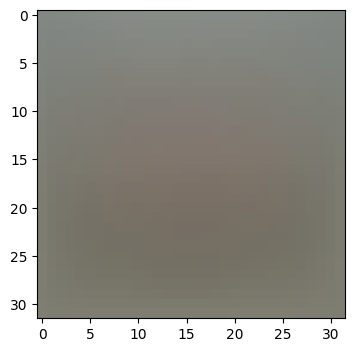

In [29]:
mean_image = np.mean(svm_X_train, axis=0)
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8'))
plt.show()

In [30]:
svm_X_train -= mean_image
svm_X_val -= mean_image
svm_X_test -= mean_image
svm_X_dev -= mean_image

svm_X_train = np.hstack([svm_X_train, np.ones((svm_X_train.shape[0], 1))])
svm_X_val = np.hstack([svm_X_val, np.ones((svm_X_val.shape[0], 1))])
svm_X_test = np.hstack([svm_X_test, np.ones((svm_X_test.shape[0], 1))])
svm_X_dev = np.hstack([svm_X_dev, np.ones((svm_X_dev.shape[0], 1))])


print(svm_X_train.shape, svm_X_val.shape, svm_X_test.shape, svm_X_dev.shape)

(49000, 3073) (1000, 3073) (9000, 3073) (1000, 3073)


2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



In [31]:
from scripts.classifiers.linear_svm import svm_loss_naive
import time


W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, svm_X_dev, svm_y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.980624



2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [32]:
loss, grad = svm_loss_naive(W, svm_X_dev, svm_y_dev, 0.0)

print("============Без регуляризации=================")
from scripts.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, svm_X_dev, svm_y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

print("=================С регуляризацией====================")
loss, grad = svm_loss_naive(W, svm_X_dev, svm_y_dev, 5e2)
f = lambda w: svm_loss_naive(w, svm_X_dev, svm_y_dev, 5e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

============Без регуляризации=================
numerical: 33.919263 analytic: 33.919263, relative error: 5.890385e-12
numerical: -13.895784 analytic: -13.895784, relative error: 8.637312e-12
numerical: -25.834470 analytic: -25.834470, relative error: 1.484022e-11
numerical: 14.346871 analytic: 14.346871, relative error: 6.679444e-12
numerical: -11.120559 analytic: -11.120559, relative error: 2.759165e-11
numerical: -37.750363 analytic: -37.750363, relative error: 3.629474e-12
numerical: -2.316214 analytic: -2.316214, relative error: 2.171781e-11
numerical: 17.196789 analytic: 17.196789, relative error: 4.073988e-13
numerical: 4.302096 analytic: 4.302096, relative error: 1.817742e-11
numerical: -6.172075 analytic: -6.172075, relative error: 1.109497e-11
=================С регуляризацией====================
numerical: -60.499964 analytic: -60.499964, relative error: 1.278379e-11
numerical: 29.233504 analytic: 29.233504, relative error: 1.142827e-11
numerical: 0.706536 analytic: 0.706536,

2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [33]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, svm_X_dev, svm_y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

from scripts.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, svm_X_dev, svm_y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.415749s
Vectorized loss and gradient: computed in 0.007521s
difference: 0.000000


2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [34]:
from scripts.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(svm_X_train, svm_y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500)
toc = time.time()
print('That took %fs' % (toc - tic))

100%|██████████| 1500/1500 [00:06<00:00, 222.23it/s]

That took 6.759154s


In [35]:
y_train_pred = svm.predict(svm_X_train)
print('training accuracy: %f' % (np.mean(svm_y_train == y_train_pred), ))

training accuracy: 0.383204


In [36]:
y_val_pred = svm.predict(svm_X_val)
print('validation accuracy: %f' % (np.mean(svm_y_val == y_val_pred), ))

validation accuracy: 0.386000


2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [37]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

data = []
for i, learning_rate in enumerate(learning_rates):
    print(f"================Element {i + 1} from {len(learning_rates)} {round((i + 1) / len(learning_rates), 2) * 100}% ==========================")
    for regularization_strength in regularization_strengths:
        cross_val_scores_ = cross_val_score(
            LinearSVM,
            svm_X_train,
            svm_y_train,
            train_estimator_params=dict(learning_rate=learning_rate, reg=regularization_strength),
        )
        data.append({
            "learning_rate": learning_rate,
            "regularization_strength": regularization_strength,
            "cross_val_scores": cross_val_scores_,
            "mean": np.mean(cross_val_scores_),
            "std": np.std(cross_val_scores_),
        })

================Element 1 from 2 50.0% ==========================


100%|██████████| 100/100 [00:00<00:00, 252.51it/s]


================Element 2 from 2 100.0% ==========================


100%|██████████| 100/100 [00:00<00:00, 222.13it/s]


In [38]:
svm_cross_val_scores_df = pd.DataFrame(data=data)
svm_cross_val_scores_df.head()

,learning_rate,regularization_strength,cross_val_scores,mean,std
0,1.000000e-07,25000.0,"[0.21122448979591837, 0.21653061224489795, 0.2...",0.211898,0.004831
1,1.000000e-07,50000.0,"[0.21071428571428572, 0.21979591836734694, 0.2...",0.216837,0.003538
2,5.000000e-05,25000.0,"[0.10489795918367346, 0.14326530612244898, 0.1...",0.132531,0.021777
3,5.000000e-05,50000.0,"[0.055714285714285716, 0.062142857142857146, 0...",0.065837,0.014786


In [39]:
svm_cross_val_scores_df.sort_values(by="mean").sort_values(by="std", ascending=False)

,learning_rate,regularization_strength,cross_val_scores,mean,std
2,5.000000e-05,25000.0,"[0.10489795918367346, 0.14326530612244898, 0.1...",0.132531,0.021777
3,5.000000e-05,50000.0,"[0.055714285714285716, 0.062142857142857146, 0...",0.065837,0.014786
0,1.000000e-07,25000.0,"[0.21122448979591837, 0.21653061224489795, 0.2...",0.211898,0.004831
1,1.000000e-07,50000.0,"[0.21071428571428572, 0.21979591836734694, 0.2...",0.216837,0.003538


In [40]:
best_svm = LinearSVM()
best_svm.train(svm_X_train, svm_y_train, learning_rate=5e-5, reg=2.5e4)
print(f"Accuracy: {accuracy(svm_y_test, best_svm.predict(svm_X_test))}")

100%|██████████| 100/100 [00:00<00:00, 198.55it/s]

Accuracy: 0.17155555555555554


2.9 Сделайте выводы по второй части задания

__Выводы:__

1. В зависимости от регуляризации и скорости обучения зависит точность SVM. При определенной комбинации можно добиться минимальной ошибки.

2. Параметр регуляризации влияет на точность SVM.

## 3.  Построение softmax-классификатора

3.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [41]:
num_train = 49000
num_val = 1000
num_test = 9000
num_dev = 1000

softmax_X_train = X_train[range(num_train)]
softmax_y_train = y_train[range(num_train)]

softmax_X_val = X_train[range(num_train, num_train + num_val)]
softmax_y_val = y_train[range(num_train, num_train + num_val)]

softmax_X_test = X_test[range(num_test)]
softmax_y_test = y_test[range(num_test)]

softmax_X_dev = X_test[range(num_test, num_test + num_val)]
softmax_y_dev = y_test[range(num_test, num_test + num_val)]
softmax_X_train = np.reshape(softmax_X_train, (softmax_X_train.shape[0], -1)).astype(np.float64)
softmax_y_train = np.reshape(softmax_y_train, (softmax_y_train.shape[0],))

softmax_X_val = np.reshape(softmax_X_val, (softmax_X_val.shape[0], -1)).astype(np.float64)
softmax_y_val = np.reshape(softmax_y_val, (softmax_y_val.shape[0],))

softmax_X_test = np.reshape(softmax_X_test, (softmax_X_test.shape[0], -1)).astype(np.float64)
softmax_y_test = np.reshape(softmax_y_test, (softmax_y_test.shape[0],))

softmax_X_dev = np.reshape(softmax_X_dev, (softmax_X_dev.shape[0], -1)).astype(np.float64)
softmax_y_dev = np.reshape(softmax_y_dev, (softmax_y_dev.shape[0],))
print(f"Тренировочная выборка: X={softmax_X_train.shape}, y={softmax_y_train.shape}")
print(f"Валидационная выборка: X={softmax_X_val.shape}, y={softmax_y_val.shape}")
print(f"Тестовая выборка: X={softmax_X_test.shape}, y={softmax_y_test.shape}")

Тренировочная выборка: X=(49000, 3072), y=(49000,)
Валидационная выборка: X=(1000, 3072), y=(1000,)
Тестовая выборка: X=(9000, 3072), y=(9000,)


3.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

3.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву данных и заполните ее единицами.

[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


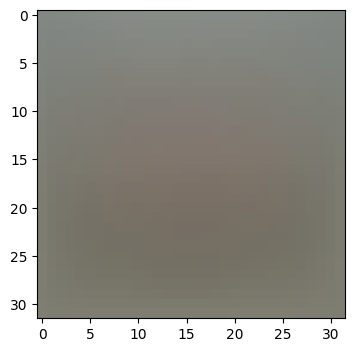

In [42]:
mean_image = np.mean(softmax_X_train, axis=0)
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8'))
plt.show()

In [43]:
softmax_X_train -= mean_image
softmax_X_val -= mean_image
softmax_X_test -= mean_image
softmax_X_dev -= mean_image

softmax_X_train = np.hstack([softmax_X_train, np.ones((softmax_X_train.shape[0], 1))])
softmax_X_val = np.hstack([softmax_X_val, np.ones((softmax_X_val.shape[0], 1))])
softmax_X_test = np.hstack([softmax_X_test, np.ones((softmax_X_test.shape[0], 1))])
softmax_X_dev = np.hstack([softmax_X_dev, np.ones((softmax_X_dev.shape[0], 1))])

print(softmax_X_train.shape, softmax_X_val.shape, softmax_X_test.shape, softmax_X_dev.shape)

(49000, 3073) (1000, 3073) (9000, 3073) (1000, 3073)


3.4 Реализуйте функции в classifiers/softmax.py




In [44]:
from scripts.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, softmax_X_dev, softmax_y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.325495
sanity check: 2.302585


3.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [45]:
loss, grad = softmax_loss_naive(W, softmax_X_dev, softmax_y_dev, 0.0)


from scripts.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, softmax_X_dev, softmax_y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = softmax_loss_naive(W, softmax_X_dev, softmax_y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, softmax_X_dev, softmax_y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.670111 analytic: -0.670111, relative error: 1.333839e-08
numerical: 1.984798 analytic: 1.984798, relative error: 2.412047e-09
numerical: 3.976754 analytic: 3.976754, relative error: 1.622457e-08
numerical: -1.171709 analytic: -1.171709, relative error: 8.966704e-10
numerical: -0.112727 analytic: -0.112727, relative error: 8.124761e-08
numerical: 0.595270 analytic: 0.595270, relative error: 3.473296e-08
numerical: 0.937623 analytic: 0.937623, relative error: 8.103999e-08
numerical: -0.740653 analytic: -0.740653, relative error: 3.162008e-09
numerical: -0.820047 analytic: -0.820047, relative error: 3.420106e-08
numerical: 2.248439 analytic: 2.248439, relative error: 1.632622e-08
numerical: 1.899493 analytic: 1.899493, relative error: 7.233639e-09
numerical: 0.733098 analytic: 0.733098, relative error: 4.863294e-09
numerical: 0.761425 analytic: 0.761425, relative error: 1.004093e-07
numerical: 0.276934 analytic: 0.276934, relative error: 3.252786e-08
numerical: -2.435316 ana

3.6 Сравните softmax_loss_naive и softmax_loss_vectorized реализации

In [46]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, softmax_X_dev, softmax_y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from scripts.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, softmax_X_dev, softmax_y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.325495e+00 computed in 0.670597s
vectorized loss: 2.325495e+00 computed in 0.019110s
Loss difference: 0.000000
Gradient difference: 0.000000


3.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

3.8 Обучите Softmax-классификатор и оцените accuracy на тестовой выборке.

In [47]:
from scripts.classifiers.linear_classifier import Softmax

softmax_classifier = Softmax()
softmax_classifier.train(softmax_X_train, softmax_y_train)
print(f"Accuracy: {accuracy(softmax_y_test, softmax_classifier.predict(softmax_X_test))}")

100%|██████████| 100/100 [00:00<00:00, 151.53it/s]

Accuracy: 0.09922222222222223


3.9 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [48]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

data = []
for i, learning_rate in enumerate(learning_rates):
    print(f"================Element {i + 1} from {len(learning_rates)} {round((i + 1) / len(learning_rates), 2) * 100}% ==========================")
    for regularization_strength in regularization_strengths:
        cross_val_scores_ = cross_val_score(
            Softmax,
            softmax_X_train,
            softmax_y_train,
            train_estimator_params=dict(learning_rate=learning_rate, reg=regularization_strength),
        )
        data.append({
            "learning_rate": learning_rate,
            "regularization_strength": regularization_strength,
            "cross_val_scores": cross_val_scores_,
            "mean": np.mean(cross_val_scores_),
            "std": np.std(cross_val_scores_),
        })

================Element 1 from 2 50.0% ==========================


100%|██████████| 100/100 [00:00<00:00, 188.96it/s]


================Element 2 from 2 100.0% ==========================


100%|██████████| 100/100 [00:00<00:00, 138.58it/s]


In [49]:
softmax_cross_val_scores_df = pd.DataFrame(data=data)
svm_cross_val_scores_df.sort_values(by="mean").sort_values(by="std", ascending=False)

,learning_rate,regularization_strength,cross_val_scores,mean,std
2,5.000000e-05,25000.0,"[0.10489795918367346, 0.14326530612244898, 0.1...",0.132531,0.021777
3,5.000000e-05,50000.0,"[0.055714285714285716, 0.062142857142857146, 0...",0.065837,0.014786
0,1.000000e-07,25000.0,"[0.21122448979591837, 0.21653061224489795, 0.2...",0.211898,0.004831
1,1.000000e-07,50000.0,"[0.21071428571428572, 0.21979591836734694, 0.2...",0.216837,0.003538


In [50]:
best_softmax_classifier = Softmax()
best_softmax_classifier.train(softmax_X_train, softmax_y_train, learning_rate=5e-5, reg=2.5e4)
print(f"Accuracy: {accuracy(softmax_y_test, best_softmax_classifier.predict(softmax_X_test))}")

100%|██████████| 100/100 [00:00<00:00, 111.24it/s]


Accuracy: 0.09022222222222222


3.10 Сделайте выводы по третьей части задания

__Выводы:__

1. В зависимости от регуляризации и скорости обучения зависит точность SVM. При определенной комбинации можно добиться минимальной ошибки.

2. SVM классификатор точнее Softmax.